## 1. Загрузка данных и первичный анализ

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('Mall_Customers.csv')
print("Размерность данных:", df.shape)
print("\nПервые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())
print("\nПроверка на пропуски:")
print(df.isnull().sum())

Размерность данных: (200, 5)

Первые 5 строк данных:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
mem

- Количество пропусков: отстутствует
- Признаки кластаризации которые будут использоваться: Age Annual Income, Spending Score.

## 2. Описательная статистика и распределения признаков

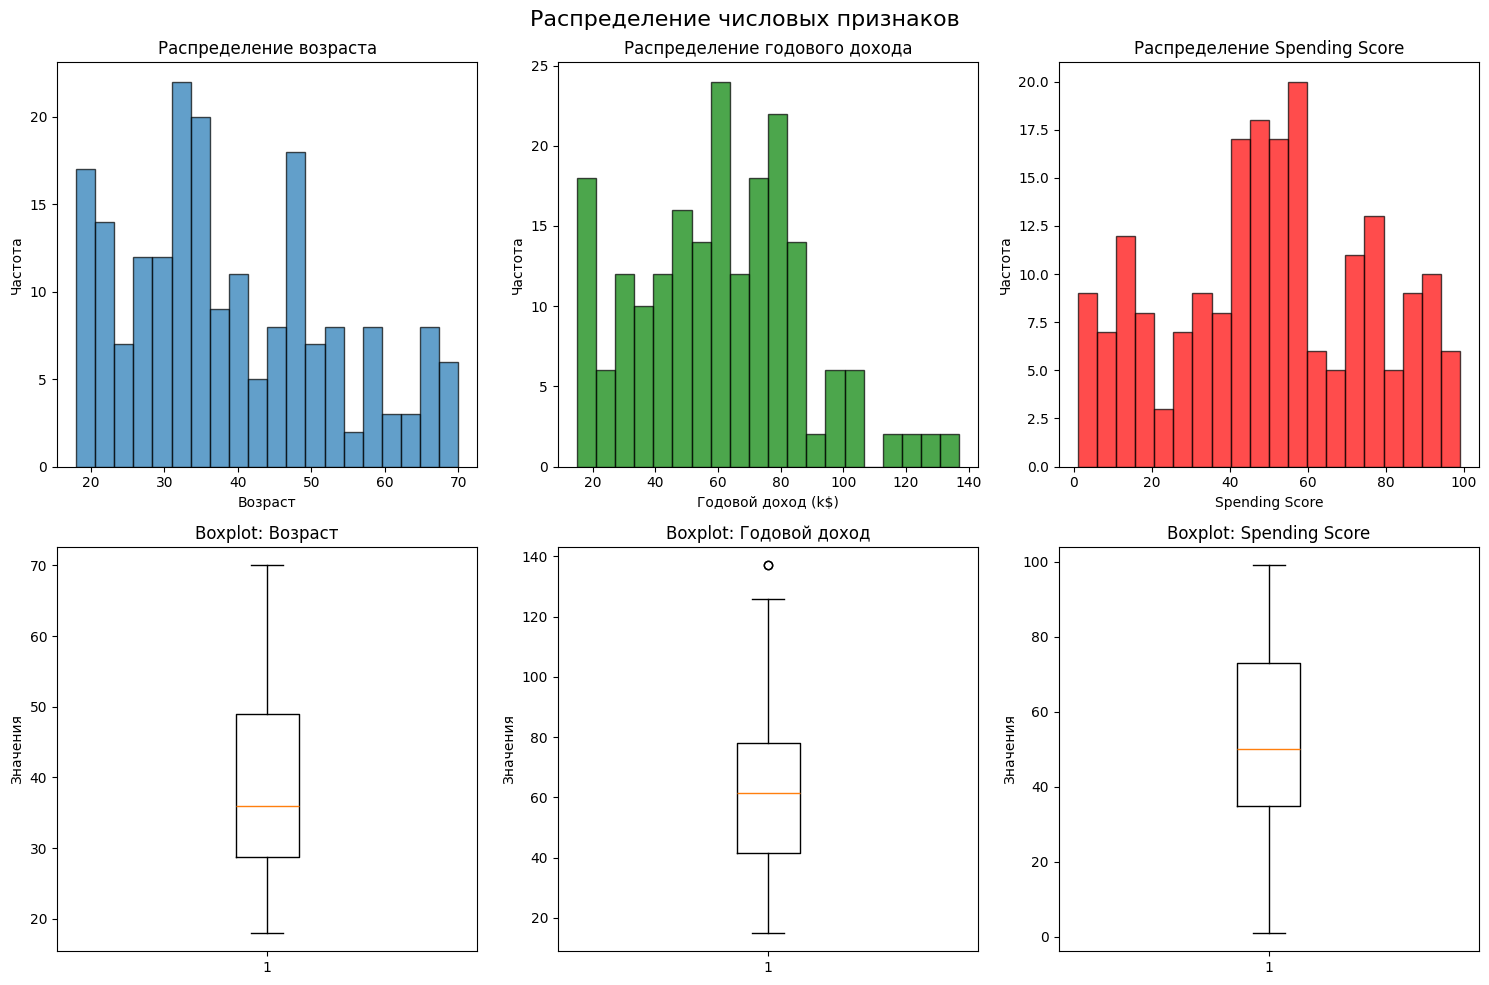

Age: 0 выбросов
Annual Income (k$): 2 выбросов
Spending Score (1-100): 0 выбросов
Выбросы удалены.



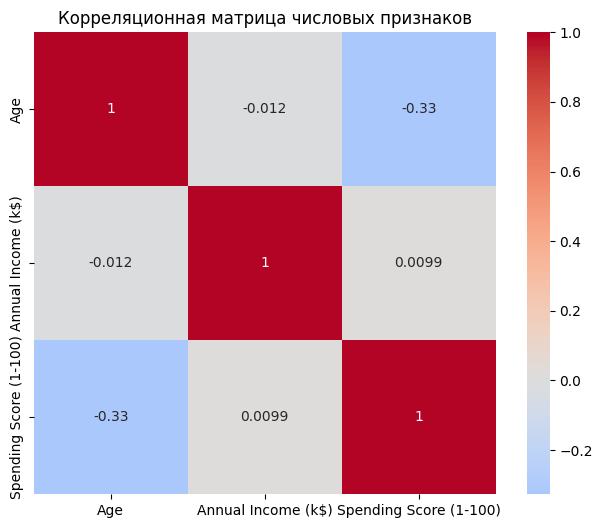

In [182]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение числовых признаков', fontsize=16)

axes[0, 0].hist(df['Age'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение возраста')
axes[0, 0].set_xlabel('Возраст')
axes[0, 0].set_ylabel('Частота')

axes[0, 1].hist(df['Annual Income (k$)'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Распределение годового дохода')
axes[0, 1].set_xlabel('Годовой доход (k$)')
axes[0, 1].set_ylabel('Частота')

axes[0, 2].hist(df['Spending Score (1-100)'], bins=20, edgecolor='black', alpha=0.7, color='red')
axes[0, 2].set_title('Распределение Spending Score')
axes[0, 2].set_xlabel('Spending Score')
axes[0, 2].set_ylabel('Частота')

axes[1, 0].boxplot(df['Age'])
axes[1, 0].set_title('Boxplot: Возраст')
axes[1, 0].set_ylabel('Значения')

axes[1, 1].boxplot(df['Annual Income (k$)'])
axes[1, 1].set_title('Boxplot: Годовой доход')
axes[1, 1].set_ylabel('Значения')

axes[1, 2].boxplot(df['Spending Score (1-100)'])
axes[1, 2].set_title('Boxplot: Spending Score')
axes[1, 2].set_ylabel('Значения')

plt.tight_layout()
plt.show()

for col in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} выбросов")
print("Выбросы удалены.\n")
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

На корреляционной диаграмме видно что между элементами нет сильной корреляции

## 3. Матрица диаграмм рассеяния


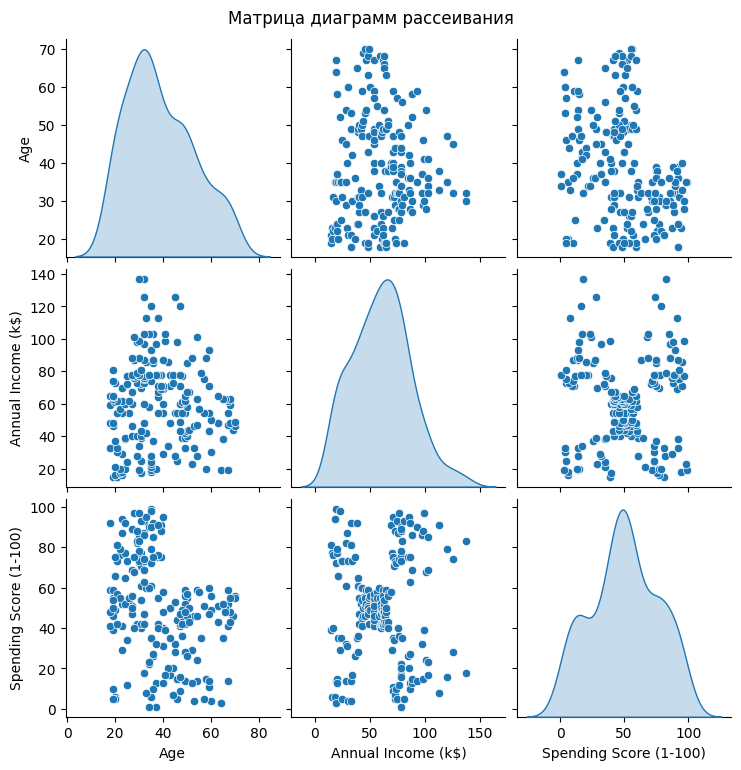

In [183]:
sns.pairplot(df[numerical_features], diag_kind='kde', height=2.5)
plt.suptitle('Матрица диаграмм рассеивания', y=1.02)
plt.show()

По диаграмме рассеивания видно 5 кластеров которые собираются в сферическую форму с большой плотностью что подходит для кластера K-means.

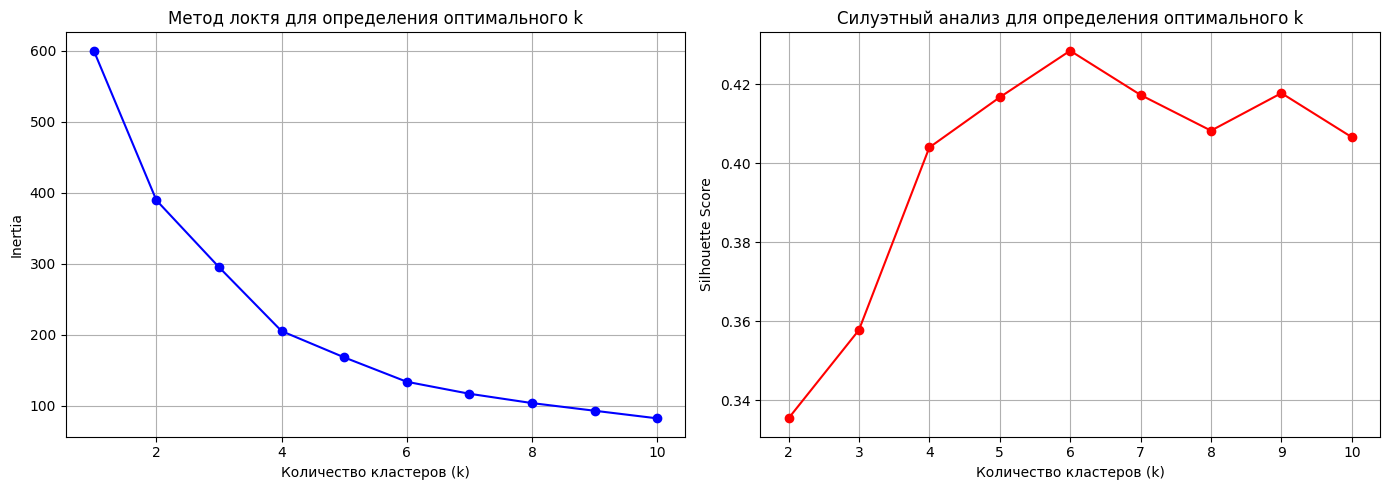

Анализ оптимального количества кластеров:
Наиболее вероятное количество кластеров по силуэтному анализу: 6
Максимальный силуэтный score: 0.428


In [184]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertia, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Метод локтя для определения оптимального k')
axes[0].grid(True)

axes[1].plot(range(2, 11), silhouette_scores, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Силуэтный анализ для определения оптимального k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("Анализ оптимального количества кластеров:")
print(f"Наиболее вероятное количество кластеров по силуэтному анализу: {range(2, 11)[np.argmax(silhouette_scores)]}")
print(f"Максимальный силуэтный score: {max(silhouette_scores):.3f}")

#### На графике метода локтя видно:
- "Локоть" наблюдается при k=5 - после этой точки снижение инерции замедляется
- Кривая становится более пологой после k=5-6
#### Вывод по методу локтя: Оптимальное k находится в диапазоне 4-6 кластеров, наиболее вероятно k=5.

#### На графике силуэтного видно:
- Пик силуэтного коэффициента при k=6 (≈0.42)
#### Вывод по силуэтному анализу: Оптимальное k=6, так как это дает максимальный силуэтный коэффициент.

#### Обоснование выбора k=6:
- Силуэтный коэффициент при k=6 (0.428) выше, чем при k=5 (0.41)

In [185]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_scaled)

df['KMeans_Cluster'] = kmeans_labels

centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
print("Центры кластеров (оригинальные масштабы):")
print(centroids_df)

cluster_counts = df['KMeans_Cluster'].value_counts().sort_index()
print("\nРаспределение объектов по кластерам:")
print(cluster_counts)

Центры кластеров (оригинальные масштабы):
         Age  Annual Income (k$)  Spending Score (1-100)
0  41.939394           88.939394               16.969697
1  56.333333           54.266667               49.066667
2  25.250000           25.833333               76.916667
3  32.692308           86.538462               82.128205
4  26.684211           57.578947               47.789474
5  45.523810           26.285714               19.380952

Распределение объектов по кластерам:
KMeans_Cluster
0    33
1    45
2    24
3    39
4    38
5    21
Name: count, dtype: int64


## ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ
### Основные принципы:
Агломеративный подход (снизу вверх):
- Начинается с каждого объекта как отдельного кластера
- Последовательно объединяет наиболее близкие класт

In [186]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

df['Hierarchical_Cluster'] = hierarchical_labels

print("Распределение объектов по кластерам (иерархическая кластеризация):")
print(df['Hierarchical_Cluster'].value_counts().sort_index())

Распределение объектов по кластерам (иерархическая кластеризация):
Hierarchical_Cluster
0    45
1    45
2    39
3    28
4    22
5    21
Name: count, dtype: int64


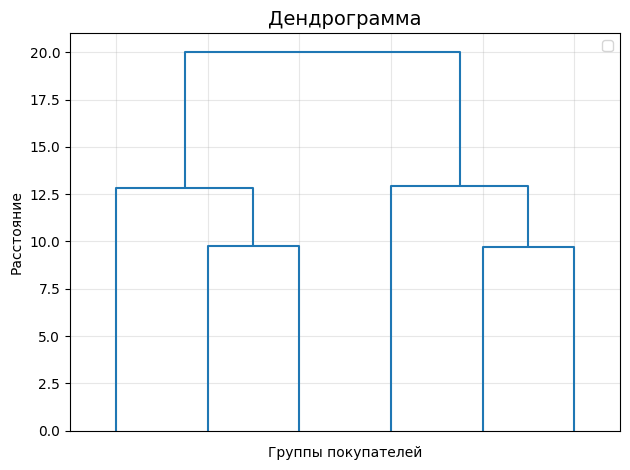

In [187]:

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

sample_indices = np.random.choice(len(X_scaled), 50, replace=False)
X_sample = X_scaled[sample_indices]

linked = linkage(X_sample, method='ward')

linked_full = linkage(X_scaled, method='ward')
dendrogram(linked_full,
           truncate_mode='lastp',
           p=optimal_k,
           show_leaf_counts=False,
           leaf_rotation=90,
           color_threshold=linked_full[-optimal_k + 1, 2]
          )

plt.title(f'Дендрограмма', fontsize=14)
plt.xlabel(f'Группы покупателей')
plt.ylabel('Расстояние')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [188]:

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_scaled, kmeans_labels)

hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
hierarchical_calinski = calinski_harabasz_score(X_scaled, hierarchical_labels)
hierarchical_davies = davies_bouldin_score(X_scaled, hierarchical_labels)

metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'K-means': [kmeans_silhouette, kmeans_calinski, kmeans_davies],
    'Иерархическая': [hierarchical_silhouette, hierarchical_calinski, hierarchical_davies]
})

print("Метрики качества кластеризации:")
print(metrics_df.to_string(index=False))

Метрики качества кластеризации:
                Метрика    K-means  Иерархическая
       Silhouette Score   0.427428       0.420117
Calinski-Harabasz Index 135.102217     127.986454
   Davies-Bouldin Index   0.827743       0.852102


PCA для визуализации в 2D и 3D в K-means и иерархических ккластеров

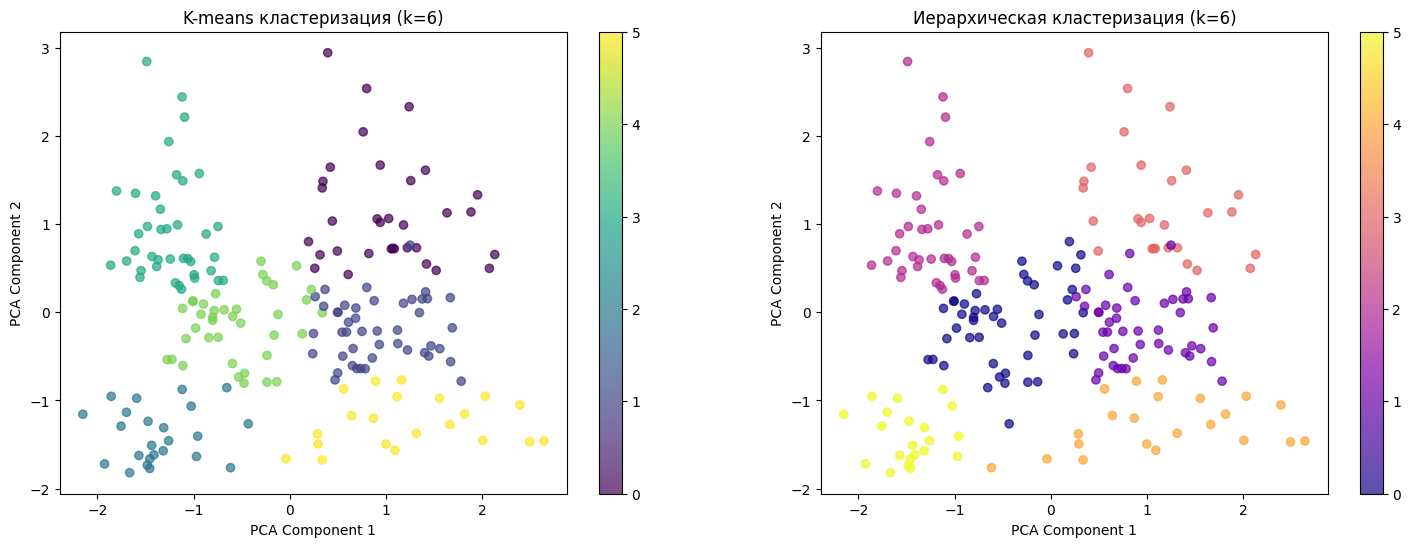

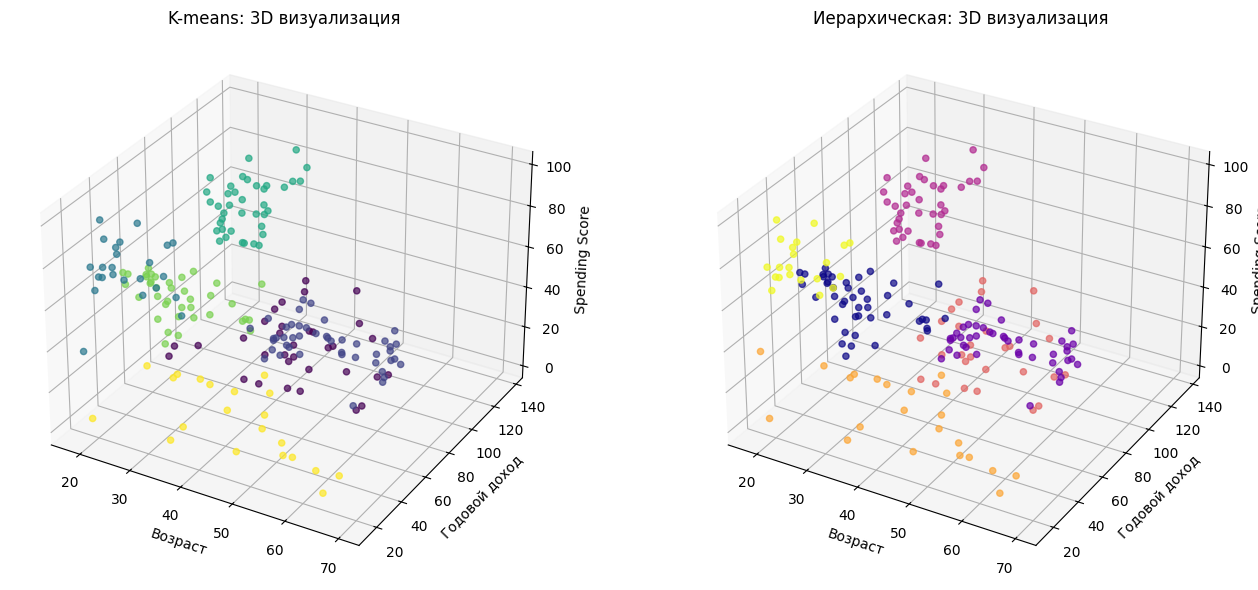

In [189]:
#2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0].set_title(f'K-means кластеризация (k={optimal_k})')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='plasma', alpha=0.7)
axes[1].set_title(f'Иерархическая кластеризация (k={optimal_k})')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
plt.colorbar(scatter2, ax=axes[1])

#3D
fig_3d = plt.figure(figsize=(14, 6))

ax1 = fig_3d.add_subplot(121, projection='3d')
scatter3d_1 = ax1.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                          c=kmeans_labels, cmap='viridis', alpha=0.7)
ax1.set_title('K-means: 3D визуализация')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Годовой доход')
ax1.set_zlabel('Spending Score')

ax2 = fig_3d.add_subplot(122, projection='3d')
scatter3d_2 = ax2.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                          c=hierarchical_labels, cmap='plasma', alpha=0.7)
ax2.set_title('Иерархическая: 3D визуализация')
ax2.set_xlabel('Возраст')
ax2.set_ylabel('Годовой доход')
ax2.set_zlabel('Spending Score')

plt.tight_layout()
plt.show()

## Анализ характеристик кластеров для K-means и определение типа кластера

In [190]:
print("Содержательная интерпретация кластеров (K-means):")

for cluster in sorted(df['KMeans_Cluster'].unique()):
    cluster_data = df[df['KMeans_Cluster'] == cluster]
    
    print(f"\n Центры кластеров {cluster}:")
    print(f"Средний возраст: {cluster_data['Age'].mean():.1f} лет")
    print(f"Средний годовой доход: {cluster_data['Annual Income (k$)'].mean():.1f} тыс.$")
    print(f"Средний Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}")
    
    age = cluster_data['Age'].mean()
    income = cluster_data['Annual Income (k$)'].mean()
    spending = cluster_data['Spending Score (1-100)'].mean()

print("\n\nРаспределение по полу в кластерах (K-means):")
gender_cluster = pd.crosstab(df['KMeans_Cluster'], df['Gender'], normalize='index') * 100
print(gender_cluster.round(1))

Содержательная интерпретация кластеров (K-means):

 Центры кластеров 0:
Средний возраст: 41.9 лет
Средний годовой доход: 88.9 тыс.$
Средний Spending Score: 17.0

 Центры кластеров 1:
Средний возраст: 56.3 лет
Средний годовой доход: 54.3 тыс.$
Средний Spending Score: 49.1

 Центры кластеров 2:
Средний возраст: 25.2 лет
Средний годовой доход: 25.8 тыс.$
Средний Spending Score: 76.9

 Центры кластеров 3:
Средний возраст: 32.7 лет
Средний годовой доход: 86.5 тыс.$
Средний Spending Score: 82.1

 Центры кластеров 4:
Средний возраст: 26.7 лет
Средний годовой доход: 57.6 тыс.$
Средний Spending Score: 47.8

 Центры кластеров 5:
Средний возраст: 45.5 лет
Средний годовой доход: 26.3 тыс.$
Средний Spending Score: 19.4


Распределение по полу в кластерах (K-means):
Gender          Female  Male
KMeans_Cluster              
0                 42.4  57.6
1                 57.8  42.2
2                 58.3  41.7
3                 53.8  46.2
4                 63.2  36.8
5                 61.9  38.1


## Исследование влияния количества кластеров на метрики качества

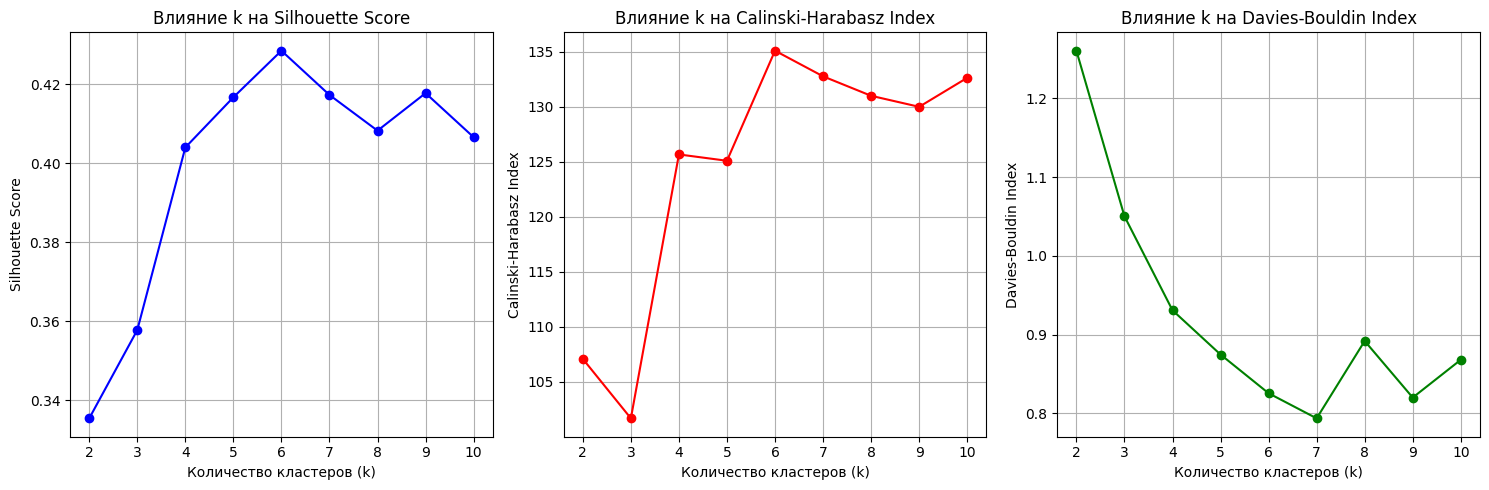

Оптимальное количество кластеров по разным метрикам:
По Silhouette Score: k = 6
По Calinski-Harabasz Index: k = 6
По Davies-Bouldin Index: k = 7


In [191]:
k_values = range(2, 11)
silhouette_scores_kmeans = []
calinski_scores_kmeans = []
davies_scores_kmeans = []

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, labels_temp))
    calinski_scores_kmeans.append(calinski_harabasz_score(X_scaled, labels_temp))
    davies_scores_kmeans.append(davies_bouldin_score(X_scaled, labels_temp))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(k_values, silhouette_scores_kmeans, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Влияние k на Silhouette Score')
axes[0].grid(True)

axes[1].plot(k_values, calinski_scores_kmeans, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Влияние k на Calinski-Harabasz Index')
axes[1].grid(True)

axes[2].plot(k_values, davies_scores_kmeans, 'go-')
axes[2].set_xlabel('Количество кластеров (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Влияние k на Davies-Bouldin Index')
axes[2].grid(True)

plt.tight_layout()
plt.show()

optimal_k_silhouette = k_values[np.argmax(silhouette_scores_kmeans)]
optimal_k_calinski = k_values[np.argmax(calinski_scores_kmeans)]
optimal_k_davies = k_values[np.argmin(davies_scores_kmeans)]

print("Оптимальное количество кластеров по разным метрикам:")
print(f"По Silhouette Score: k = {optimal_k_silhouette}")
print(f"По Calinski-Harabasz Index: k = {optimal_k_calinski}")
print(f"По Davies-Bouldin Index: k = {optimal_k_davies}")

In [192]:
ari_score = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi_score = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)

print("Сравнение результатов кластеризации:")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

comparison_df = pd.DataFrame({
    'Метод': ['K-means', 'Иерархическая'],
    'Silhouette': [kmeans_silhouette, hierarchical_silhouette],
    'Calinski-Harabasz': [kmeans_calinski, hierarchical_calinski],
    'Davies-Bouldin': [kmeans_davies, hierarchical_davies],
    'Стабильность': ['Высокая', 'Средняя'],
    'Скорость': ['Быстрая', 'Медленная'],
    'Интерпретируемость': ['Высокая', 'Средняя']
})

print("\n\nСводное сравнение методов кластеризации:")
print(comparison_df.to_string(index=False))

Сравнение результатов кластеризации:
Adjusted Rand Index (ARI): 0.8809
Normalized Mutual Information (NMI): 0.8918


Сводное сравнение методов кластеризации:
        Метод  Silhouette  Calinski-Harabasz  Davies-Bouldin Стабильность  Скорость Интерпретируемость
      K-means    0.427428         135.102217        0.827743      Высокая   Быстрая            Высокая
Иерархическая    0.420117         127.986454        0.852102      Средняя Медленная            Средняя
